In [1]:
!pip install pycox

     |████████████████████████████████| 73 kB 1.4 MB/s 
     |████████████████████████████████| 69 kB 5.2 MB/s 
     |████████████████████████████████| 41 kB 576 kB/s 
     |████████████████████████████████| 2.0 MB 41.4 MB/s 
     |████████████████████████████████| 357 kB 42.0 MB/s 
     |████████████████████████████████| 2.4 MB 54.8 MB/s 
     |████████████████████████████████| 48 kB 5.6 MB/s 
     |████████████████████████████████| 126 kB 18.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchtuples

In [14]:
import torch
import torchtuples as tt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

from pycox.datasets import metabric
from pycox.models import CoxPH
from pycox.models import CoxCC
from pycox.evaluation import EvalSurv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import numpy as np
import os
import pandas as pd
from typing import Optional
import collections

In [5]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [6]:
path_dir = r'/content/drive/MyDrive'
OV_RNa_seq = pd.read_csv(os.path.join(path_dir, 'Flux-data/2000-var-Meta.csv'), header=None)
#OV_RNa_seq = OV_RNa_seq.T
header = OV_RNa_seq.iloc[0]
OV_RNa_seq = OV_RNa_seq[1:]
OV_RNa_seq = OV_RNa_seq.rename(columns=header)
OV_RNa_seq['EnsemblgeneID'] = OV_RNa_seq['EnsemblgeneID'].str[:12]

In [7]:
OV_RNa_seq.head

<bound method NDFrame.head of     EnsemblgeneID         C2_8  ...     C2_13075     C2_13077
1    TCGA-S9-A7J2  1189.582175  ...  338.2378182            0
2    TCGA-13-1485  2088.686873  ...  1189.830039  1189.830039
3    TCGA-25-1315  2322.528163  ...  1549.603221  549.6032207
4    TCGA-09-0369  2076.051415  ...  754.1803068  348.6692077
5    TCGA-24-1419  2631.600816  ...  1639.993837  994.8627096
..            ...          ...  ...          ...          ...
423  TCGA-29-1784  2093.825581  ...   1348.06097  1322.244599
424  TCGA-13-0725    1518.8208  ...  1426.569664  1426.569664
425  TCGA-13-1481  2430.071501  ...         1000            0
426  TCGA-61-1907  2376.439593  ...  2640.213734  1640.213734
427  TCGA-24-2254   1218.27431  ...  823.5979155  481.7585798

[427 rows x 2001 columns]>

In [8]:
OV_RNa_seq.dropna(inplace=True)
Survival_Data = pd.read_excel(os.path.join(path_dir, 'survival-data/survival.xlsx'), sheet_name='TCGA-CDR', usecols="A,B,Y, Z")
Survival_Data.dropna(inplace=True)
Survival_Data_ov = Survival_Data.loc[Survival_Data['type'] == "OV"]

OV_RNa_seq_sur = pd.merge(OV_RNa_seq, Survival_Data_ov, on='EnsemblgeneID')
print(OV_RNa_seq_sur.shape)
OV_RNa_seq_sur.head()
OV_RNa_seq_sur = OV_RNa_seq_sur.loc[:, OV_RNa_seq_sur.isin([' ', 'NULL', 0]).mean() < .70]
print(OV_RNa_seq_sur.shape)

(424, 2004)
(424, 2004)


normalizing data

In [9]:
y = OV_RNa_seq_sur[['OS.time','OS']]
X = OV_RNa_seq_sur.drop(['OS.time','OS','type','EnsemblgeneID'], axis=1)
patient_name=OV_RNa_seq_sur[['EnsemblgeneID']]

In [10]:
def normalize(X_train,X_val,X_test):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train).astype(np.float32).astype('float32')
    X_val = scaler.transform(X_val).astype(np.float32).astype('float32')
    X_test = scaler.transform(X_test).astype(np.float32).astype('float32')
    return X_train,X_val,X_test
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

get_target = lambda OV_RNa_seq_sur: (OV_RNa_seq_sur['OS.time'].values, OV_RNa_seq_sur['OS'].values)

Train, val, test shape run: 1 (305, 2000) (34, 2000) (85, 2000)
0:	[0s / 0s],		train_loss: 0.9298,	val_loss: 0.6734
1:	[0s / 0s],		train_loss: 0.7628,	val_loss: 0.7072
2:	[0s / 0s],		train_loss: 0.6859,	val_loss: 0.6389
3:	[0s / 0s],		train_loss: 0.7675,	val_loss: 0.6485
4:	[0s / 0s],		train_loss: 0.7508,	val_loss: 0.6819
5:	[0s / 0s],		train_loss: 0.6784,	val_loss: 0.6705
6:	[0s / 0s],		train_loss: 0.6155,	val_loss: 0.6557
7:	[0s / 1s],		train_loss: 0.6131,	val_loss: 0.6591
8:	[0s / 1s],		train_loss: 0.6055,	val_loss: 0.8427
9:	[0s / 1s],		train_loss: 0.6301,	val_loss: 0.6946
10:	[0s / 1s],		train_loss: 0.5151,	val_loss: 0.6248
11:	[0s / 1s],		train_loss: 0.5587,	val_loss: 0.7142
12:	[0s / 1s],		train_loss: 0.5679,	val_loss: 0.6973
13:	[0s / 2s],		train_loss: 0.5431,	val_loss: 0.7334
14:	[0s / 2s],		train_loss: 0.6586,	val_loss: 0.6954
15:	[0s / 2s],		train_loss: 0.4803,	val_loss: 0.7258
16:	[0s / 3s],		train_loss: 0.5734,	val_loss: 0.7099
17:	[0s / 3s],		train_loss: 0.6181,	val_loss:

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


1 Transcriptomic C-Index 0.4995689655172414
Train, val, test shape run: 2 (305, 2000) (34, 2000) (85, 2000)
0:	[0s / 0s],		train_loss: 0.8932,	val_loss: 0.7405
1:	[0s / 0s],		train_loss: 0.7718,	val_loss: 0.6828
2:	[0s / 0s],		train_loss: 0.6848,	val_loss: 0.7050
3:	[0s / 0s],		train_loss: 0.6710,	val_loss: 0.6951
4:	[0s / 0s],		train_loss: 0.6575,	val_loss: 0.7136
5:	[0s / 0s],		train_loss: 0.6718,	val_loss: 0.7171
6:	[0s / 0s],		train_loss: 0.6154,	val_loss: 0.7851
7:	[0s / 1s],		train_loss: 0.5725,	val_loss: 0.7709
8:	[0s / 1s],		train_loss: 0.5830,	val_loss: 0.9451
9:	[0s / 1s],		train_loss: 0.5986,	val_loss: 0.7203
10:	[0s / 1s],		train_loss: 0.5504,	val_loss: 0.8253
11:	[0s / 1s],		train_loss: 0.5723,	val_loss: 0.7995
2 Transcriptomic C-Index 0.5866141732283464
Train, val, test shape run: 3 (305, 2000) (34, 2000) (85, 2000)
0:	[0s / 0s],		train_loss: 0.8136,	val_loss: 0.7211
1:	[0s / 0s],		train_loss: 0.8908,	val_loss: 0.7609
2:	[0s / 0s],		train_loss: 0.7863,	val_loss: 0.7272
3:

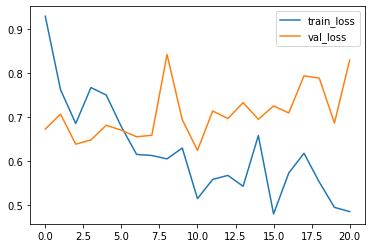

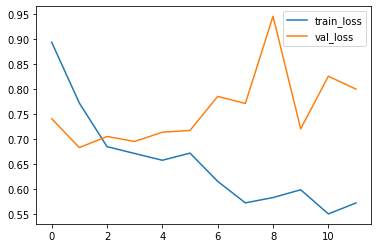

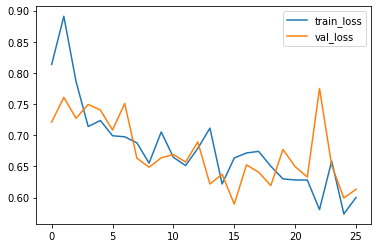

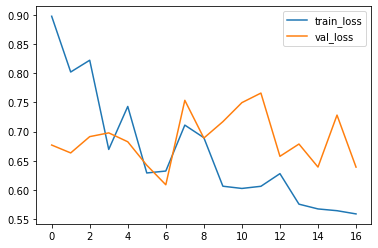

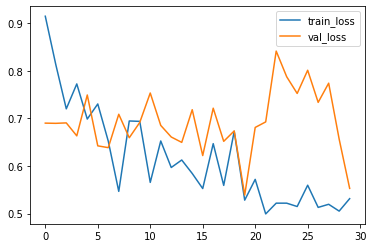

In [15]:

in_features = X.shape[1]
verbose = True
batch_size = 16
epochs = 30
out_features = 1
index_test = []
feature_vectore = np.zeros([0, 32], dtype=np.float32)

cv = KFold(n_splits=3, shuffle=True, random_state=0)
i=1
for train_ix, test_ix in cv.split(X):
	
	# split data
	X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
	y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

	# get validation set
	X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

	# Normalise data
	X_train,X_val,X_test = normalize(X_train,X_val,X_test)
	#X_test = normalize(X_test)
	#X_val = normalize(X_val)
	print('Train, val, test shape run:', i, X_train.shape, X_val.shape, X_test.shape)
 
	# convert to event + duration
	y_train= get_target(y_train)
	durations_test, events_test = get_target(y_test)
	y_val= get_target(y_val)
	val_g = X_val, y_val

	# Model
	torch.manual_seed(56) 
	net = torch.nn.Sequential(
   	collections.OrderedDict(
      [
         ("x1", torch.nn.Linear(in_features, 512)),
         ("x2", torch.nn.ReLU()),
         ("x3", torch.nn.BatchNorm1d(512)),
         ("x4", torch.nn.Dropout(0.6)),
         ("x5", torch.nn.Linear(512, 32)),
         ("x6", torch.nn.ReLU()),
         ("x7", torch.nn.BatchNorm1d(32)),
         ("x8", torch.nn.Dropout(0.6)),
         ("x9", torch.nn.Linear(32, out_features)),
      ]
   )
)
	# Same output number
	model = CoxCC(net, tt.optim.Adam)
	model.optimizer.set_lr(0.01)
	lrfinder = model.lr_finder(X_train, y_train, batch_size, tolerance=10)
	lrfinder.get_best_lr()

	callbacks = [tt.callbacks.EarlyStopping()]
	
	log = model.fit(X_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val_g, val_batch_size=batch_size)

	_ = log.plot()

	features = {}
	model.net.x7.register_forward_hook(get_features('x7'))
	_ = model.compute_baseline_hazards()
	surv = model.predict_surv_df(X_test)

	#  Feature extraction
	extracted = features['x7'].cpu().numpy()
	feature_vectore = np.append(feature_vectore, extracted, axis=0)

	ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
	print(i, "Transcriptomic C-Index", ev.concordance_td())
	i+=1
	index_test = np.append(index_test, test_ix)
  
 
   



In [ ]:
index_test = index_test.astype(int)
names_index = patient_name.values[index_test]

In [ ]:
#bb=np.concatenate((names_index,feature_vectore), axis=1)
#np.savetxt("/content/drive/MyDrive/Feature-vector/Same-S/Meta.csv", bb, delimiter=",",fmt='%s')